#### Задача

Необходимо найти зависимости между ранками по блокам и изменением цены (можно ранками по изменению цены). Изменение цены можно проанализировать за разный период, возможно квартал к кварталу нет зависимости, но есть 3г к 3годам и т.п. Также возможно в качестве зависимой переменной взять не изменение цены, а разницу между изменением цены компании и всего рынка(SPY). Анализ можно сделать в разрезе любых качественных характеристик компаний и их сочетаний (отрасли, страны, валюта, доступность биржы, размер компании и.т.п). Результаты представить с описание полученных результатов и проделанной работы в формате Word или PDF

- CompId	- Id компании
- RANK_Credit_prc	- Ранк по блоку от 0 до 100
- RANK_Forecast_prc	- Ранк по блоку от 0 до 100
- RANK_Growth_prc	- Ранк по блоку от 0 до 100
- RANK_Value_prc	- Ранк по блоку от 0 до 100
- RANK_ESG_prc	-  Ранк по блоку от 0 до 100
- RANK_Price_momentum_prc	- Ранк по блоку от 0 до 100
- RANK_Dividend_prc	- Ранк по блоку от 0 до 100
- RANK_Industry_prc	- Ранк по блоку от 0 до 100
- Rank_RANK_4_prc	- Итоговый ранк на основе нескольких блоков. Как он считается не важно сейчас
- Rank_RANK_5_prc	- Итоговый ранк на основе нескольких блоков. Как он считается не важно сейчас
- Rank_RANK_6_prc	- Итоговый ранк на основе нескольких блоков. Как он считается не важно сейчас
- Rank_RANK_8_prc	- Итоговый ранк на основе нескольких блоков. Как он считается не важно сейчас
- Perf_2021.10.01	- Изменение цены по компании с момента инвестиций по сегодняшний день
- Rank_Perf_2021.10.01_prc	
- Date_round	- Дата расчета (округленная)
- Perf_1Y	- Изменение цены по компании год к году
- Rank_Perf_1Y_prc	- Ранк по компании на основе изменении цены год к году
- Perf_3M	- Изменение цены по компании квартал к кварталу
- Rank_Perf_3M_prc	- Ранк по компании на основе изменении цены квартал к кварталу
- Perf_3Y	- Изменение цены по компании за 3 года
- Rank_Perf_3Y_prc	- Ранк по компании на основе изменении цены за 3 года
- Perf_5Y	- Изменение цены по компании за 5 лет
- Rank_Perf_5Y_prc	- Ранк по компании на основе изменении цены за 5 лет
- Company_Common_Name	- Имя компании
- Country_of_Headquarters	- Страна
- Currency	- Валюта
- GICS_Sector_Name	- Индустрия (уровень 1)
- GICS_Industry_Group_Name	- Индустрия (уровень 2)
- GICS_Industry_Name	- Индустрия (уровень 3)
- GICS_Sub_Industry_Name	- Индустрия (уровень 4)
- IPO_Date	- Дата IPO
- SPBEX_MOEX	- Признак доступности биржы
- Minor_Region_of_Headquarters	- Регион
- Region_of_Headquarters	- Континент
- MCap_group	- Группа по капитализации компании
- Perf_SPY_3M	- Изменение цены SPY (бенчмарк рынка) квартал к кварталу
- erf_SPY_1Y	- Изменение цены SPY (бенчмарк рынка) год к году
- Perf_SPY_3Y	- Изменение цены SPY (бенчмарк рынка) 3 года
- Perf_SPY_5Y	- Изменение цены SPY (бенчмарк рынка) 5 лет


Итак, простыми словами, как я вижу задачу:  
У нас есть ранки по блокам - это наши целевые переменные,
есть изменения цены за периоды - это наши признаки.
есть качественные характеристики - отрасль, регион, валюта и т.д.
Соответственно, нужно найти корреляцию между целевыми и признаками в разрезе качественных характеристик.

In [44]:
# Импортируем нужные модули
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_column', None)

import warnings
warnings.filterwarnings('ignore')

In [144]:
def make_unique_features(df, list_features):
    '''
    для каждой фичи в списке, делаем список уникальных значений
    возвращаем сисок списков из уникальных значений 
    '''
    dict_unique_features = {}
    for feature in list_features:
        dict_unique_features[feature] = list(df[feature].unique())
    return dict_unique_features


def make_df_corr(data, ranks, cat_features, features):
    """
    в функцию передаем: 
    - dataframe,
    - ранки,
    - категориальные признаки, по которым делаем срез,
    - и числовые признаки, по которым делаем корреляцию
    """
    # Сгруппируем табличку по cat_features, чтобы дергать уникальные сочетания
    data_grouped = data.groupby(cat_features, as_index=False)['CompId'].count()

    # сделаем новую табличку
    columns = (['Rank_Name'] + cat_features + [x + '_corr' for x in features] + ['max_corr', 'max_corr_name'])
    df = pd.DataFrame(columns=columns)

    for rank in ranks:    
        for i in range(data_grouped.shape[0]):
            new_df = data[[rank]+cat_features+features]
            # добавляем уникальную строчку из признаков для среза
            for cat_feature in cat_features:
                new_df = new_df[new_df[cat_feature] == data_grouped[cat_feature].iloc[i]]

            # список кат_переменных
            cat_features_names = list(data_grouped.iloc[i,:-1])
            # Корреляция Пирсона для выбранного Ранка и выбранных фичей
            corr_features = list(round(new_df[[rank]+features].corr().iloc[0][1:], 3))
            # max из указанных корреляций           
            corr_max = [max(corr_features)] if abs(max(corr_features))>abs(min(corr_features)) else [min(corr_features)]
            # название признака с которым корреляция наибольшая
            corr_max_name = [[x + '_corr' for x in features][corr_features.index(corr_max[0])]]


            new_str = [rank] + cat_features_names + corr_features + corr_max + corr_max_name

            #add row to end of DataFrame
            df.loc[len(df.index)] = new_str

    df.dropna(subset=['max_corr'], axis=0, inplace=True)
    return df

def look_ranks(ranks, df):
    """
    Строим графики распределения максимальной корреляции и Какой признак чаще всего оказывается максимально коррелированным
    """
    print('Смотрим разные ранки')

    sns.set(rc={'figure.figsize':(20,8*len(ranks))})

    i = 0
    j = 0
    while True:
        if df[df['Rank_Name'] == ranks[j]].shape[0] == 0:
            i+=2
            j+=1
            continue
        i += 1
        plt.subplots_adjust(wspace=0.3, hspace=0.4)
        plt.subplot(2*len(ranks), 2, i)
        plt.xlabel('распределение')
        #plt.ylabel('частота')
        plt.title(ranks[j])
        sns.histplot(x=df[df['Rank_Name'] == ranks[j]]['max_corr'], data=df[df['Rank_Name'] == ranks[j]], bins=50)
        
        i += 1
        plt.subplot(2*len(ranks), 2, i)
        plt.xlabel('количество')
        #plt.ylabel('признак')
        plt.title(ranks[j] + ' частота признаков в максимальной корреляции')
        df[df['Rank_Name'] == ranks[j]]['max_corr_name'].value_counts(ascending=True).plot(kind='barh')
        

        j += 1
        if j >= len(ranks):
            break 

In [3]:
# Загрузим данные
data = pd.read_excel('Задача для кандидата на DS.xlsx')

data.head(3)

,CompId,RANK_Credit_prc,RANK_Forecast_prc,RANK_Growth_prc,RANK_Value_prc,RANK_ESG_prc,RANK_Price_momentum_prc,RANK_Dividend_prc,RANK_Industry_prc,Rank_RANK_4_prc,Rank_RANK_5_prc,Rank_RANK_6_prc,Rank_RANK_8_prc,Perf_2021.10.01,Rank_Perf_2021.10.01_prc,Date_round,Perf_1Y,Rank_Perf_1Y_prc,Perf_3M,Rank_Perf_3M_prc,Perf_3Y,Rank_Perf_3Y_prc,Perf_5Y,Rank_Perf_5Y_prc,Company_Common_Name,Country_of_Headquarters,Currency,GICS_Sector_Name,GICS_Industry_Group_Name,GICS_Industry_Name,GICS_Sub_Industry_Name,IPO_Date,SPBEX_MOEX,Minor_Region_of_Headquarters,Region_of_Headquarters,MCap_group,Perf_SPY_3M,Perf_SPY_1Y,Perf_SPY_3Y,Perf_SPY_5Y
0,000001.SZ,NaN,0.603605,0.872050,0.902324,NaN,NaN,NaN,0.738635,0.976340,0.981235,0.772611,0.994755,2.105145,0.685185,2012-01-01,0.038105,0.349752,0.007121,0.226423,0.978867,0.730983,0.462959,0.447512,Ping An Bank Co Ltd,China,CNY,Financials,Banks,Banks,Diversified Banks,1991-04-03,0.0,Eastern Asia,Asia,Средние,0.121992,0.134741,0.637769,0.781116
1,000001.SZ,NaN,0.665458,0.979995,0.831396,NaN,NaN,NaN,0.591777,0.987688,0.989798,0.813673,0.990502,2.083189,0.724148,2012-04-01,0.298633,0.761919,-0.043440,0.535568,0.955475,0.716026,0.476506,0.486910,Ping An Bank Co Ltd,China,CNY,Financials,Banks,Banks,Diversified Banks,1991-04-03,0.0,Eastern Asia,Asia,Средние,-0.033414,0.112634,0.466018,0.674171
2,000001.SZ,NaN,0.501821,0.987609,0.918640,NaN,NaN,NaN,0.642661,0.982624,0.985731,0.764557,0.989643,2.223204,0.716152,2012-07-01,0.089207,0.459772,-0.124409,0.104265,1.264306,0.719093,0.604814,0.495781,Ping An Bank Co Ltd,China,CNY,Financials,Banks,Banks,Diversified Banks,1991-04-03,0.0,Eastern Asia,Asia,Средние,0.057786,0.178649,0.512435,0.776570


In [4]:
print('Коротко о датасете:')
print(f'Размер датасета: {data.shape}')
print(f'Количетсво компаний в датасете: {data["CompId"].nunique()}')
print(f'Количетсво стран в датасете: {data["Country_of_Headquarters"].nunique()}')
print(f'Количетсво валют в датасете: {data["Currency"].nunique()}')
print(f'Количетсво отраслей в датасете: {data["GICS_Sector_Name"].nunique()}')
print(f'Количетсво индустриальных групп в датасете: {data["GICS_Industry_Group_Name"].nunique()}')
print(f'Количетсво регионов в датасете: {data["Region_of_Headquarters"].nunique()}')

Коротко о датасете:
Размер датасета: (455941, 40)
Количетсво компаний в датасете: 15791
Количетсво стран в датасете: 105
Количетсво валют в датасете: 65
Количетсво отраслей в датасете: 11
Количетсво индустриальных групп в датасете: 24
Количетсво регионов в датасете: 5


Анализ будем делать в разрезе: Страна, Отрасль, Индустриальная группа, Валюта

In [5]:
# добавим признаки
data['diff_SPY_1Y'] = data['Perf_1Y'] - data['Perf_SPY_1Y']
data['diff_SPY_3M'] = data['Perf_3M'] - data['Perf_SPY_3M']
data['diff_SPY_3Y'] = data['Perf_3Y'] - data['Perf_SPY_3Y']
data['diff_SPY_5Y'] = data['Perf_5Y'] - data['Perf_SPY_5Y']

# В качестве числовых признаков оставим следующие
# за рамками анализа посмотрел, что между изменением цены и его Ранком - существенная корреляция, поэтому оставил только цену 
features = ['Perf_1Y', 'Perf_3M', 'Perf_3Y', 'Perf_5Y', 'diff_SPY_1Y', 'diff_SPY_3M', 'diff_SPY_3Y', 'diff_SPY_5Y']

In [6]:
# посмотрим целевые переменные. (сразу видно, что в некоторых много пропусков)

ranks = ['RANK_Credit_prc',
         'RANK_Forecast_prc',
         'RANK_Growth_prc',
         'RANK_Value_prc',
         'RANK_ESG_prc',
         'RANK_Price_momentum_prc',
         'RANK_Dividend_prc',
         'RANK_Industry_prc']

for rank in ranks:
    print(f'{rank} имеет {data[rank].isna().sum()/data.shape[0]*100:.2f} % пропусков')

RANK_Credit_prc имеет 2.63 % пропусков
RANK_Forecast_prc имеет 24.74 % пропусков
RANK_Growth_prc имеет 3.34 % пропусков
RANK_Value_prc имеет 0.15 % пропусков
RANK_ESG_prc имеет 54.57 % пропусков
RANK_Price_momentum_prc имеет 76.98 % пропусков
RANK_Dividend_prc имеет 95.88 % пропусков
RANK_Industry_prc имеет 0.00 % пропусков


Много пропусков. Есть Ранки, в которых пропущено больше половины значений. Сразу удалять не будем, попробуем что-нибудь с этим сделать.

,Rank_Name,Country_of_Headquarters,Currency,GICS_Sector_Name,GICS_Industry_Group_Name,Perf_1Y_corr,Perf_3M_corr,Perf_3Y_corr,Perf_5Y_corr,diff_SPY_1Y_corr,diff_SPY_3M_corr,diff_SPY_3Y_corr,diff_SPY_5Y_corr,max_corr,max_corr_name
10020,RANK_Industry_prc,Ireland; Republic of,GBp,Industrials,Capital Goods,-0.236,-0.193,-0.263,-0.483,-0.233,-0.209,-0.260,-0.519,-0.519,diff_SPY_5Y_corr
1160,RANK_Credit_prc,Taiwan,TWD,Financials,Banks,0.150,0.082,0.218,0.391,0.033,0.015,0.242,0.335,0.391,Perf_5Y_corr
2370,RANK_Forecast_prc,Singapore,SGD,Energy,Energy,0.230,0.192,0.096,0.650,0.199,0.257,0.132,0.606,0.650,Perf_5Y_corr
780,RANK_Credit_prc,Mexico,MXN,Consumer Discretionary,Automobiles & Components,-0.202,-0.149,0.009,-0.062,-0.152,-0.110,0.539,-0.792,-0.792,diff_SPY_5Y_corr
7327,RANK_Price_momentum_prc,Ireland; Republic of,USD,Information Technology,Software & Services,0.036,0.101,-0.209,-0.029,-0.379,0.073,-0.501,-0.638,-0.638,diff_SPY_5Y_corr


Смотрим разные ранки


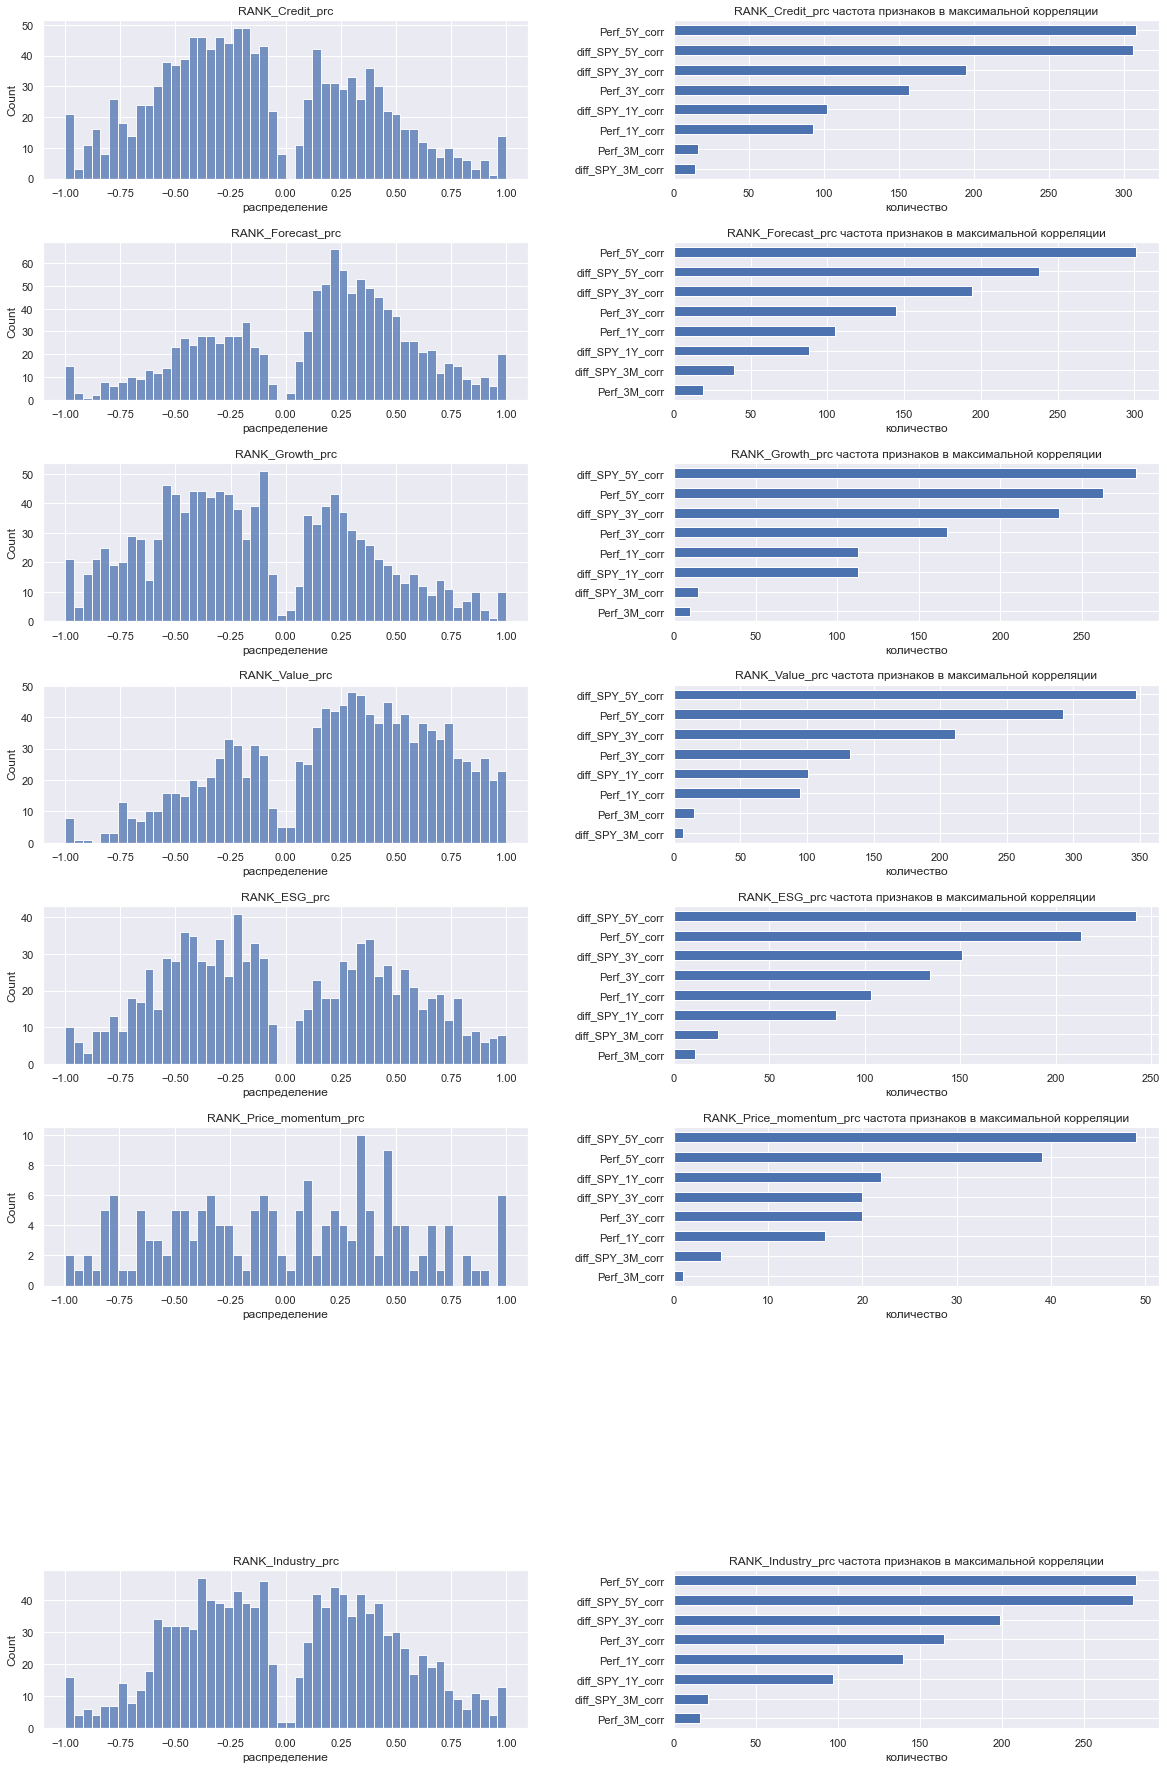

In [152]:
# Итак, можно выбрать ранки, числовые фичи и категориальные, по которым будем делать срез
# Для первой пробы оставим все ранки, числовые - изменения за все периоды и с разницей к SPY
# Срез сделаем по Стране, Валюте, Сектору и Группе

ranks = ['RANK_Credit_prc',
         'RANK_Forecast_prc',
         'RANK_Growth_prc',
         'RANK_Value_prc',
         'RANK_ESG_prc',
         'RANK_Price_momentum_prc',
         'RANK_Dividend_prc',
         'RANK_Industry_prc']

# Выберем кат_признаки, по которым будем делать срез
cat_features = ['Country_of_Headquarters',	'Currency',	'GICS_Sector_Name',	'GICS_Industry_Group_Name']

# строим таблицу с корреляциями
df_new = make_df_corr(data, ranks, cat_features, features)
display(df_new.sample(5))

# Строим графики распределения максимальных корреляций и какие признаки имеют наибольшую корреляцию
look_ranks(ranks, df_new)

##### Проанализировав графики можно сделать следующие выводы:
- Чаще всего наибольшую корреляцию между Ранками и Изменением цены составляют 5-летние диапазоны
- При указаном разрезе для анализа (уникальные выборки по Стране, Валюте, Сектору, Группе) корреяция выявлена, но в зависимости от Конкретной Страны-Валюты-Сектора-Группы она может быть как прямая, так и обратная, как более выраженная, так и менее выраженная
- Корреляция 1 и -1 очевидно обусловлены тем, что по таким группам была только одна запись
- Графики распределения корреляций по ранкам схожи между собой

,Rank_Name,Country_of_Headquarters,GICS_Sector_Name,Perf_1Y_corr,Perf_3M_corr,Perf_3Y_corr,Perf_5Y_corr,diff_SPY_1Y_corr,diff_SPY_3M_corr,diff_SPY_3Y_corr,diff_SPY_5Y_corr,max_corr,max_corr_name
1173,RANK_Forecast_prc,Russia,Financials,0.125,0.108,0.216,0.295,0.135,0.134,0.233,0.227,0.295,Perf_5Y_corr
272,RANK_Value_prc,Israel,Energy,0.158,0.115,0.160,0.280,0.147,0.109,0.180,0.257,0.280,Perf_5Y_corr
1328,RANK_Forecast_prc,Vietnam,Health Care,0.320,0.159,0.651,0.259,0.430,0.240,0.730,0.447,0.730,diff_SPY_3Y_corr
1032,RANK_Forecast_prc,Malaysia,Materials,0.231,0.155,0.428,0.279,0.252,0.157,0.435,0.292,0.435,diff_SPY_3Y_corr
227,RANK_Value_prc,Hungary,Financials,0.082,0.137,-0.221,0.105,0.017,0.071,-0.211,0.185,-0.221,Perf_3Y_corr



Смотрим разные ранки


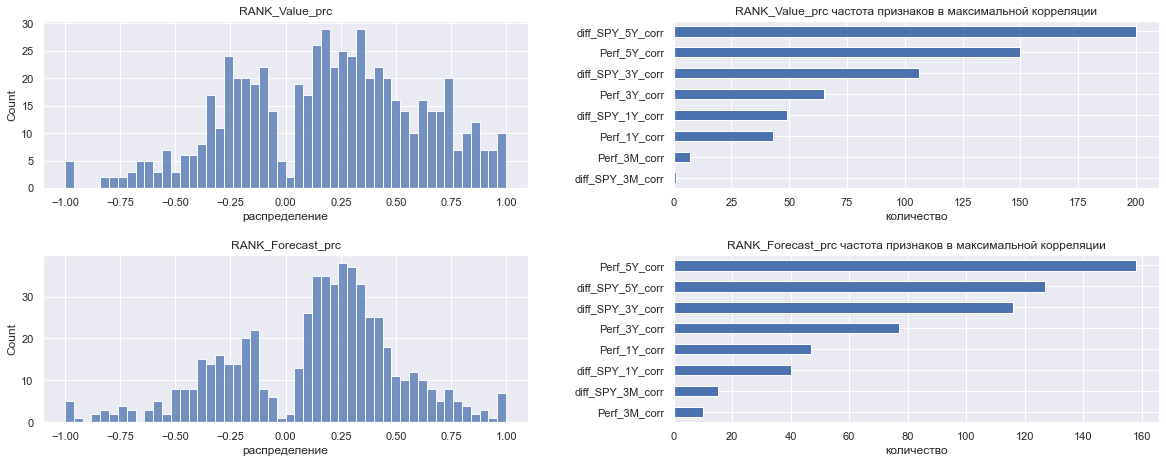

In [158]:
#Можно еще поиграться с ранками и срезами

ranks = ['RANK_Value_prc',
         'RANK_Forecast_prc']

# Выберем кат_признаки, по которым будем делать срез
cat_features = ['Country_of_Headquarters',	'GICS_Sector_Name']
# числовые признаки, по отношению к которым смотрим корреляцию
features = ['Perf_1Y', 'Perf_3M', 'Perf_3Y', 'Perf_5Y', 'diff_SPY_1Y', 'diff_SPY_3M', 'diff_SPY_3Y', 'diff_SPY_5Y']

df_new = make_df_corr(data, ranks, cat_features, features)
display(df_new.sample(5))
print('')
look_ranks(ranks, df_new)

##### Дальнейший анализ других срезов:
- По этим графикам можно сделать заключение, что данный срез Страна-Отрасль имеет такие же зависимости, как и предыдущий

,Rank_Name,Country_of_Headquarters,Perf_1Y_corr,Perf_3M_corr,Perf_3Y_corr,Perf_5Y_corr,diff_SPY_1Y_corr,diff_SPY_3M_corr,diff_SPY_3Y_corr,diff_SPY_5Y_corr,max_corr,max_corr_name
23,RANK_Value_prc,Estonia,0.442,0.643,1.000,NaN,0.391,0.740,1.000,NaN,1.000,Perf_3Y_corr
146,RANK_Forecast_prc,Israel,0.094,0.030,0.220,0.277,0.097,0.038,0.223,0.278,0.278,diff_SPY_5Y_corr
128,RANK_Forecast_prc,Estonia,-0.740,-0.224,NaN,NaN,0.361,-0.025,NaN,NaN,-0.740,Perf_1Y_corr
51,RANK_Value_prc,Liechtenstein,0.525,0.270,0.345,0.450,0.552,0.256,0.426,0.350,0.552,diff_SPY_1Y_corr
96,RANK_Value_prc,Turkey,-0.078,-0.042,-0.072,-0.021,-0.074,-0.040,-0.069,-0.018,-0.078,Perf_1Y_corr



Смотрим разные ранки


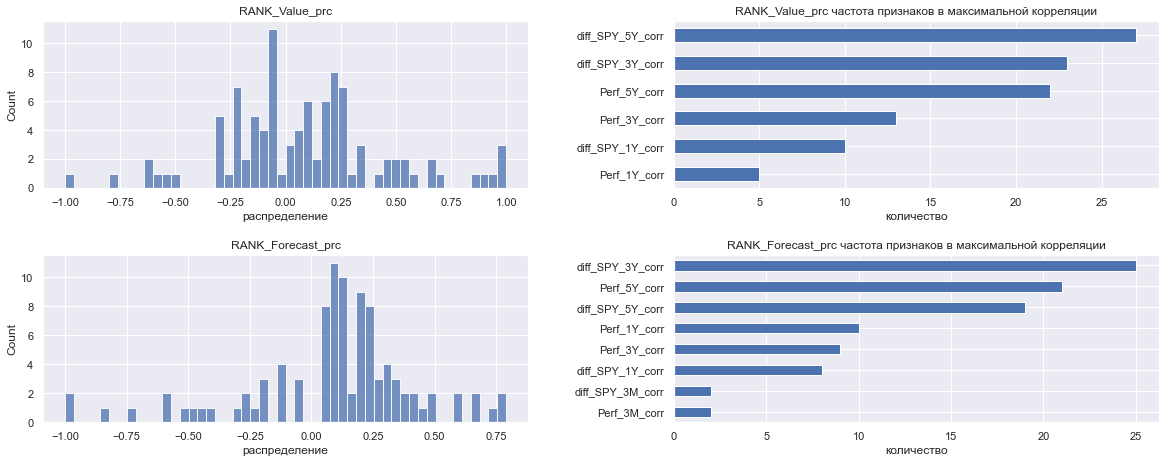

In [159]:
#Можно еще поиграться с ранками и срезами

ranks = ['RANK_Value_prc',
         'RANK_Forecast_prc']

# Выберем кат_признаки, по которым будем делать срез
cat_features = ['Country_of_Headquarters']
# числовые признаки, по отношению к которым смотрим корреляцию
features = ['Perf_1Y', 'Perf_3M', 'Perf_3Y', 'Perf_5Y', 'diff_SPY_1Y', 'diff_SPY_3M', 'diff_SPY_3Y', 'diff_SPY_5Y']

df_new = make_df_corr(data, ranks, cat_features, features)
display(df_new.sample(5))
print('')
look_ranks(ranks, df_new)

##### Дальнейший анализ других срезов:
- По этим графикам можно сделать заключение, если оставляеи только один категориальный признак, то корреляция снижается (замешиваются в группы, например различные отрасли, или наоборот, если делаем только по отраслям, то замешиваются страны и т.д.)

,Rank_Name,Country_of_Headquarters,Currency,Perf_1Y_corr,Perf_3M_corr,Perf_3Y_corr,Perf_5Y_corr,diff_SPY_1Y_corr,diff_SPY_3M_corr,diff_SPY_3Y_corr,diff_SPY_5Y_corr,max_corr,max_corr_name
153,RANK_Value_prc,Puerto Rico,USD,0.103,0.053,0.105,0.091,0.119,0.059,0.087,0.090,0.119,diff_SPY_1Y_corr
53,RANK_Value_prc,Finland,SEK,0.027,0.252,-0.251,0.270,-0.063,0.235,-0.277,0.198,-0.277,diff_SPY_3Y_corr
23,RANK_Value_prc,Brazil,USD,0.211,0.139,-0.178,NaN,0.270,0.166,-0.227,NaN,0.270,diff_SPY_1Y_corr
18,RANK_Value_prc,Bermuda,GBp,0.331,0.244,0.391,0.218,0.429,0.295,0.453,0.259,0.453,diff_SPY_3Y_corr
120,RANK_Value_prc,Malta,EUR,-0.015,-0.236,-0.382,-0.500,-0.004,-0.273,-0.040,-0.342,-0.500,Perf_5Y_corr



Смотрим разные ранки


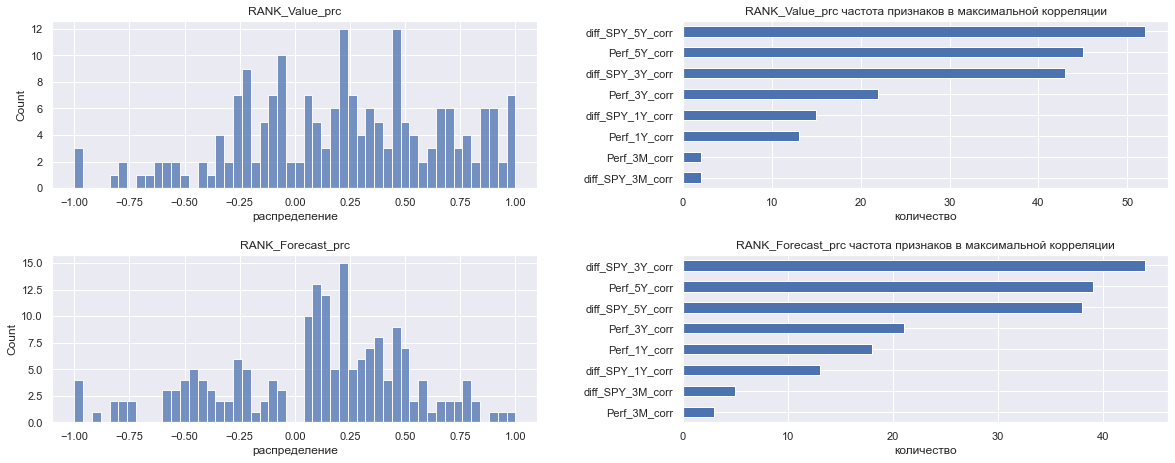

In [155]:
#Можно еще поиграться с ранками и срезами

ranks = ['RANK_Value_prc',
         'RANK_Forecast_prc']

# Выберем кат_признаки, по которым будем делать срез
cat_features = ['Country_of_Headquarters',	'Currency']
# числовые признаки, по отношению к которым смотрим корреляцию
features = ['Perf_1Y', 'Perf_3M', 'Perf_3Y', 'Perf_5Y', 'diff_SPY_1Y', 'diff_SPY_3M', 'diff_SPY_3Y', 'diff_SPY_5Y']

df_new = make_df_corr(data, ranks, cat_features, features)
display(df_new.sample(5))
print('')
look_ranks(ranks, df_new)

#### Выводы
Итак, что было выполнено:
- посмотрел на представленный датасет, много признаков с пропусками
- Для анализа оставил только Ранки, категориальные признаки, по которым делали срезы, и числовые признаки (изменение цены за периоды и разницу изменений цен с ценами SPY). Ранки изменения цен не использовали. так как у них высокая корреляция с изменением цен.
- Построил таблицы корреляций между ранками и числовыми признаками в зависимости от выбранного среза
- отобразил графически распределение максимальных корреляций и кол-во признаков с наибольшей корреляцией.

##### Обобщая полученную после анализ информацию, хочу отметить следующее:  
- Наибольшая корреляция встречается чаще, как правило у более длительных периодов.
- Если делать срез по какой то одной группе, то корреляция между ранками и изменениями цен выражены меньше, чем когда срез делаем более точным, например страна-отрасль (замешивается) или страна-валюта-отрасль-группа
- для каждой уникальной группы (например страна-отрасль) есть такие, которые имеют прямую корреляцию, есть которые имеют отрицательную.
- при выборке страна-отрасль распределение корреляции Пирсона имеет два пика примерно на 0.3 и -0.3, что подтверждает наличие зависимости между Ранками и Изменением цены

